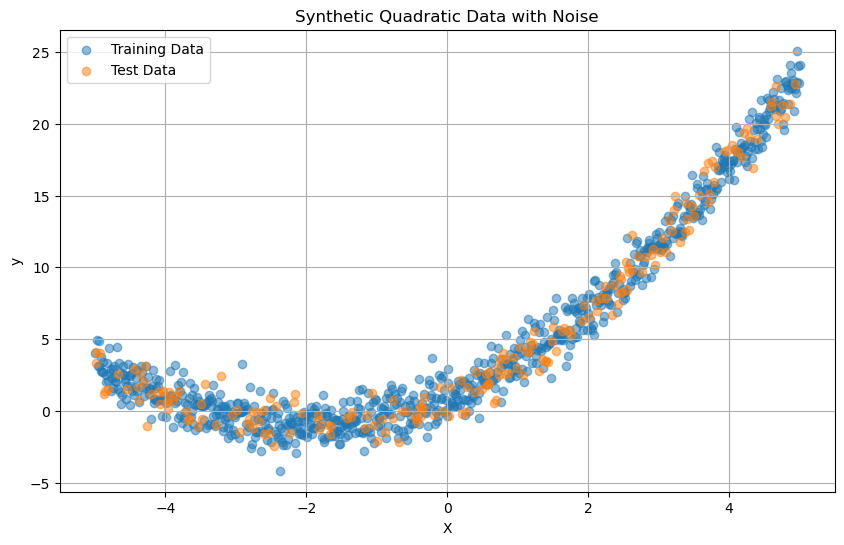

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate synthetic data for a noisy quadratic function
X = np.linspace(-5, 5, 1000).reshape(-1, 1)
y = 0.5 * X**2 + 2 * X + 1 + np.random.normal(0, 1, X.shape)

# Convert to PyTorch tensors
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

# Create random indices for shuffling
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

# Split into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(X_train.numpy(), y_train.numpy(), alpha=0.5, label='Training Data')
plt.scatter(X_test.numpy(), y_test.numpy(), alpha=0.5, label='Test Data')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Synthetic Quadratic Data with Noise')
plt.legend()
plt.grid(True)
plt.show()

# Gradient Descent vs Stochastic Gradient Descent

## Regular (Batch) Gradient Descent
- Computes gradient using the entire training dataset
- Updates model parameters once per epoch
- Advantages:
  - More stable convergence
  - Better gradient estimates
  - Parallelizable computations
- Disadvantages:
  - High memory requirements
  - Slow for large datasets
  - Can get stuck in local minima
  - Computationally expensive per update

The cost function $J(\theta)$ over all $m$ training examples:

$J(\theta) = \frac{1}{m} \sum_{i=1}^m L(h_\theta(x^{(i)}), y^{(i)})$

Parameter update:

$\theta = \theta - \alpha \nabla J(\theta)$

where:
- $\theta$: model parameters
- $\alpha$: learning rate
- $\nabla J(\theta)$: gradient of cost function over all examples
- $h_\theta(x)$: model prediction
- $L$: loss function

Epoch [1000/5000], Loss: 9.5630
Epoch [2000/5000], Loss: 0.9812
Epoch [3000/5000], Loss: 0.9630
Epoch [4000/5000], Loss: 0.9608
Epoch [5000/5000], Loss: 0.9605


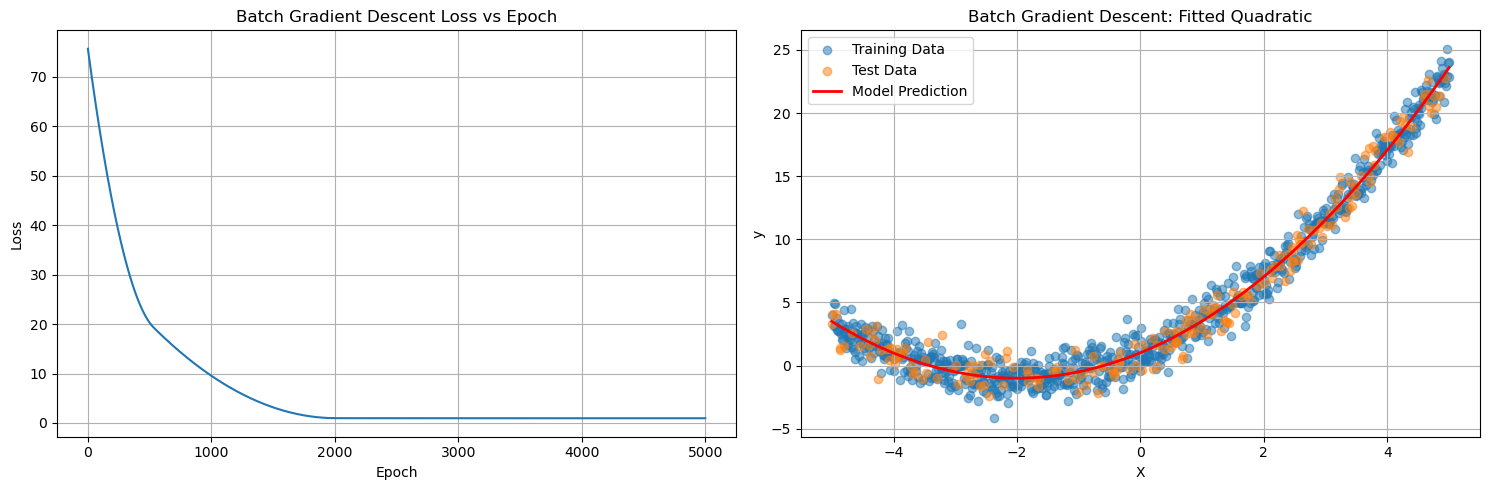


True function: y = 0.5x² + 2x + 1
Learned function: y = 0.5012x² + 2.0107x + 1.0207


In [9]:
# Define a simple quadratic model: f(x) = ax^2 + bx + c
class QuadraticModel:
    def __init__(self):
        self.a = torch.tensor([0.0], requires_grad=True)
        self.b = torch.tensor([0.0], requires_grad=True)
        self.c = torch.tensor([0.0], requires_grad=True)
    
    def forward(self, x):
        return self.a * x**2 + self.b * x + self.c
    
    def parameters(self):
        return [self.a, self.b, self.c]
    
# Initialize the model, loss function, and optimizer
model = QuadraticModel()
learning_rate = 0.001
n_epochs = 5000
losses = []

# Batch Gradient Descent training loop
for epoch in range(n_epochs):
    # Forward pass
    y_pred = model.forward(X_train)
    loss = torch.mean((y_pred - y_train)**2) # MSE loss

    # manual averaging of loss
    # loss = torch.sum((y_pred - y_train)**2)
    # loss.backward()
    # for param in model.parameters():
    #     param.grad /= len(X_train)

    loss.backward() # Backpropagation

    # Parameter update
    with torch.no_grad():
        for param in model.parameters():
            param.grad.clamp_(-1, 1)
            param -= learning_rate * param.grad
            param.grad.zero_()
    
    losses.append(loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')


# Visualize results
plt.figure(figsize=(15,5))

# Plot Loss curve
plt.subplot(1,2,1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Batch Gradient Descent Loss vs Epoch')
plt.grid(True)

# Plot 2: Fitted curve
plt.subplot(1, 2, 2)
with torch.no_grad():
    X_sorted, indices = torch.sort(X, dim=0)
    y_pred = model.forward(X_sorted)

plt.scatter(X_train.numpy(), y_train.numpy(), alpha=0.5, label='Training Data')
plt.scatter(X_test.numpy(), y_test.numpy(), alpha=0.5, label='Test Data')
plt.plot(X_sorted.numpy(), y_pred.numpy(), 'r-', label='Model Prediction', linewidth=2)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Batch Gradient Descent: Fitted Quadratic')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final parameters
print("\nTrue function: y = 0.5x² + 2x + 1")
print(f"Learned function: y = {model.a.item():.4f}x² + {model.b.item():.4f}x + {model.c.item():.4f}")

## Stochastic Gradient Descent (SGD)
- Updates parameters using single training examples
- Much more frequent parameter updates
- Advantages:
  - Lower memory requirements
  - Faster iteration speed
  - Can escape local minima due to noise
  - Works well with online learning
- Disadvantages:
  - High variance in parameter updates
  - Less stable convergence
  - May require lower learning rates

Cost function for a single example $i$:

$J_i(\theta) = L(h_\theta(x^{(i)}), y^{(i)})$

Parameter update for each example $i$:

$\theta = \theta - \alpha \nabla J_i(\theta)$

Epoch [2/10], Step [199/800], Loss: 7.8305
Epoch [3/10], Step [399/800], Loss: 28.0360
Epoch [4/10], Step [599/800], Loss: 0.8238
Epoch [5/10], Step [799/800], Loss: 0.0011
Epoch [7/10], Step [199/800], Loss: 0.6527
Epoch [8/10], Step [399/800], Loss: 0.5681
Epoch [9/10], Step [599/800], Loss: 0.0013
Epoch [10/10], Step [799/800], Loss: 0.7347


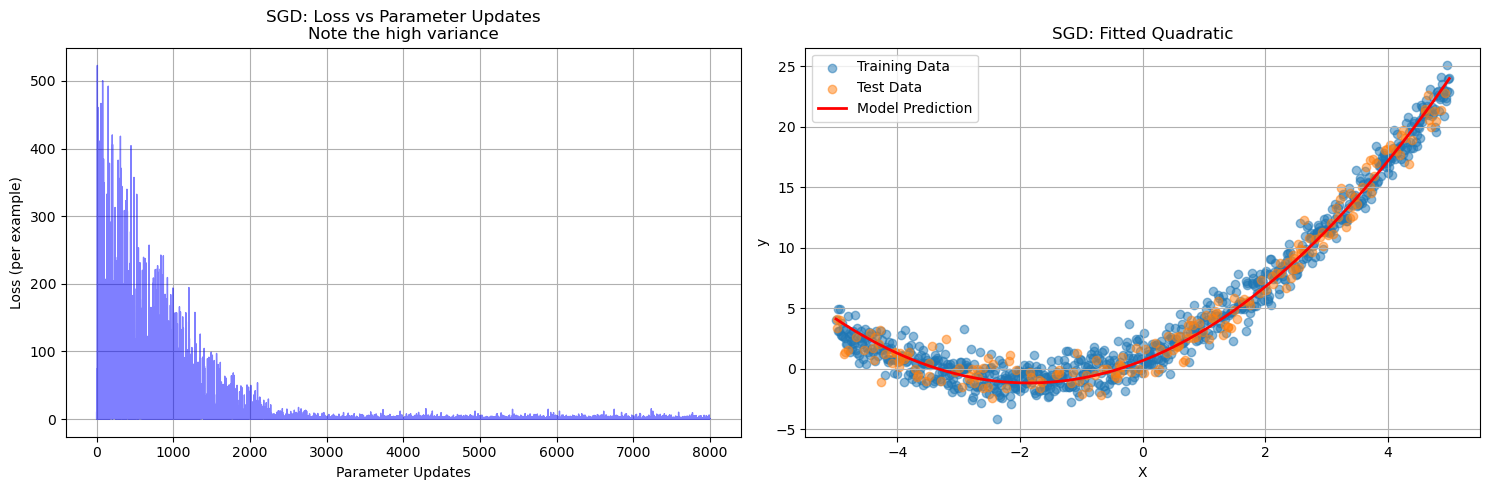


True function: y = 0.5x² + 2x + 1
Learned function: y = 0.5357x² + 1.9896x + 0.6630


In [12]:
# Use the same QuadraticModel class defined earlier
model = QuadraticModel()
learning_rate = 0.001  # Increased from 0.0001
n_epochs = 10  # Reduced epochs but we'll see more updates
losses = []  # Will store individual update losses, not epoch averages

# Stochastic Gradient Descent training loop
for epoch in range(n_epochs):
    # Shuffle the training data
    indices = torch.randperm(len(X_train))
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]
    
    # Iterate through individual examples
    for i in range(len(X_train)):
        # Get single example
        x_i = X_shuffled[i:i+1]
        y_i = y_shuffled[i:i+1]
        
        # Forward pass on single example
        y_pred = model.forward(x_i)
        loss = (y_pred - y_i)**2  # MSE loss for single example
        
        # Backward pass
        loss.backward()
        
        # Parameter update
        with torch.no_grad():
            for param in model.parameters():
                param.grad.clamp_(-1, 1)  # Gradient clipping
                param -= learning_rate * param.grad
                param.grad.zero_()
        
        # Record loss for every update
        losses.append(loss.item())
        
        # Print progress every 1000 updates
        if (epoch * len(X_train) + i + 1) % 1000 == 0:
            print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i}/{len(X_train)}], Loss: {loss.item():.4f}')

# Visualize results
plt.figure(figsize=(15,5))

# Plot Loss curve - showing individual updates with line plot
plt.subplot(1,2,1)
plt.plot(losses, 'b-', alpha=0.5, linewidth=1)  # Added line style and transparency
plt.xlabel('Parameter Updates')
plt.ylabel('Loss (per example)')
plt.title('SGD: Loss vs Parameter Updates\nNote the high variance')
plt.grid(True)

# Plot 2: Fitted curve
plt.subplot(1, 2, 2)
with torch.no_grad():
    X_sorted, indices = torch.sort(X, dim=0)
    y_pred = model.forward(X_sorted)

plt.scatter(X_train.numpy(), y_train.numpy(), alpha=0.5, label='Training Data')
plt.scatter(X_test.numpy(), y_test.numpy(), alpha=0.5, label='Test Data')
plt.plot(X_sorted.numpy(), y_pred.numpy(), 'r-', label='Model Prediction', linewidth=2)
plt.xlabel('X')
plt.ylabel('y')
plt.title('SGD: Fitted Quadratic')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final parameters
print("\nTrue function: y = 0.5x² + 2x + 1")
print(f"Learned function: y = {model.a.item():.4f}x² + {model.b.item():.4f}x + {model.c.item():.4f}")

## Mini-batch Gradient Descent
- Compromise between batch and stochastic approaches
- Uses small random batches of training data
- Common batch sizes: 32, 64, 128, 256
- Best of both worlds:
  - More stable than SGD
  - Faster than batch gradient descent
  - Memory efficient
  - Still allows parallel processing

Cost function for mini-batch of size $b$:

$J_b(\theta) = \frac{1}{b} \sum_{i=1}^b L(h_\theta(x^{(i)}), y^{(i)})$

Parameter update for each mini-batch:

$\theta = \theta - \alpha \nabla J_b(\theta)$

## Convergence Properties
- Batch GD: Converges to global minimum for convex functions, local minimum for non-convex
- SGD: Converges in probability to global/local minimum with decreasing learning rate
- Mini-batch GD: Similar to SGD but with reduced variance

## Learning Rate Schedule
Common decay formula:

$\alpha_t = \frac{\alpha_0}{1 + kt}$

where:
- $\alpha_t$: learning rate at time $t$
- $\alpha_0$: initial learning rate
- $k$: decay rate
- $t$: iteration number

## Learning Rate Considerations
- SGD often requires learning rate scheduling
- Common approaches:
  - Learning rate decay
  - Momentum
  - Adam optimizer
  - RMSprop